# BERT EN Model

### This notebook contains the implementation of the BERT model pre-trained on the english language set coming from `Datasets/BERT/train_en.csv`

### The following steps are taken to establish the model
- **Data exploration and visualization**
- **Model definition**
- **Optimizer algorithm selection**
- **Loss function selection**
- **Training loop**
- **Model saving**

In [2]:
!pip install -q keras-nlp --upgrade

In [1]:
import matplotlib.pyplot as plt
import pandas
import numpy
import keras_nlp
import keras
import tensorflow

keras.mixed_precision.set_global_policy("mixed_float16")

#### Data Exploration and Visualization

In [2]:
bert_en_dataset = pandas.read_csv("Datasets/BERT/train_en.csv")
bert_en_dataset.head()

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,label_name
0,0,a937bd90a8,"3) Dare you rise to the occasion, like Raskol...",Would you rise up and defeaat all evil lords i...,en,English,1,neutral
1,1,0abb9434d5,"He married Dona Filipa Moniz (Perestrelo), the...",He landed on the island but soon left for gree...,en,English,2,contradiction
2,2,bc52edfd5b,The contrast between the landscape of the cent...,There was a beautiful artist who painted the l...,en,English,1,neutral
3,3,62344708db,i don't know i i do i can think of all the uh ...,I know this because I own a bible.,en,English,1,neutral
4,4,03f3c9a92e,'So I assume he hacked into the autopilot and ...,I'm assuming he hacked the autopilot to bring ...,en,English,1,neutral


##### Validation to ensure the data is clean when being passed to the model

In [3]:
bert_en_dataset.isna().sum()

,0
Unnamed: 0,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0
label_name,0


In [4]:
(bert_en_dataset.lang_abv != "en").sum()

0

In [5]:
bert_en_dataset.label[~bert_en_dataset.label.isin([0, 1, 2])].any()

False

##### Descriptions and summaries of data

In [6]:
bert_en_dataset.id.count()

3435

- A fairly small dataset relatively speaking to other sources.

In [7]:
bert_en_dataset.hypothesis.describe()

,hypothesis
count,3435
unique,3435
top,Did you do it?
freq,1


In [8]:
for i in range(10):
    print(bert_en_dataset.hypothesis[i])

Would you rise up and defeaat all evil lords in the town?
He landed on the island but soon left for greener pastures, before later dying alone and childless.
There was a beautiful artist who painted the landscape of the central highlands.
I know this because I own a bible.
I'm assuming he hacked the autopilot to bring the plane down.
They would make pilgrimages to Jerusalem.
A traveler said the settlement was prospering. 
TIG funds are used to support the Technology Evolution project, a legal aid society in Cincinnati. 
I could not agree with you.
You were thought to be dead!


- All hypothesis are unique and follow the structure shown above. The premises that follow may either directly follow from the hypothesis, contradict it or not contain enough information to make a proper conclusion.

In [9]:
bert_en_dataset.premise.describe()

,premise
count,3435
unique,2380
top,We are also advocating enhanced reporting in c...
freq,3


In [10]:
for i in range(10):
    print(bert_en_dataset.premise[i])

3)  Dare you rise to the occasion, like Raskolnikov, and reject the petty rules that govern lesser men?
He married Dona Filipa Moniz (Perestrelo), the daughter of Porto Santo's first governor, and lived on the island for a period, fathering a son there.
The contrast between the landscape of the central highlands and the south coast could not be more marked.
i don't know i i do i can think of all the uh the biblical things about it too where what did they say to uh i can't think of the scripture Render unto Caesar's what is Caesar's so
'So I assume he hacked into the autopilot and reprogrammed it to-'
They returned to live in the Galilee village of Nazareth, making pilgrimages to Jerusalem.
An Indian traveler described the prosperous Bujang Valley settlement as  the seat of all felicities.  
TIG funds support the Technology Evaluation Project, an initiative of the Legal Aid Society of Cincinnati.
well i think i got to agree with you there
Say, man, don't you know you've been given up fo

- **Note:** Not all the premises that follow **are necessarily unique.** This is done to have the model be able to **recognize several conclusions that may be drawn from a hypothesis.**

In [11]:
bert_en_dataset.label.describe()

,label
count,3435.000000
mean,0.984862
std,0.823577
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


- From the five-number summary, it can be surmised that most of the data seems to contain neutral conclusions in the premises. This likely suggests that the model will need to learn and encode finer details in the premises to draw accurate conclusions and predictions.

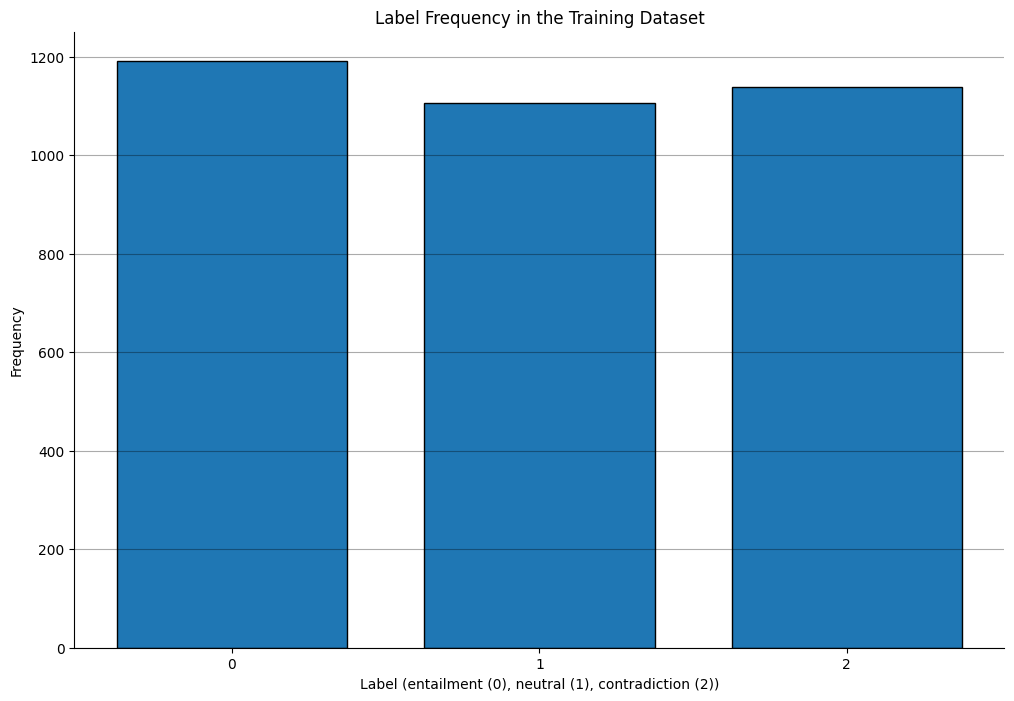

In [12]:
labels = bert_en_dataset.label.to_numpy()

plt.figure(figsize=(12, 8))

plt.hist(labels, bins=range(4), align="left", rwidth=0.75, edgecolor="black")

plt.xticks(numpy.arange(3))

for pos in ["top", "right"]:
    plt.gca().spines[pos].set_visible(False)

plt.grid(axis="y", alpha=0.33, color="black")

plt.xlabel("Label (entailment (0), neutral (1), contradiction (2))")

plt.ylabel("Frequency")

plt.title("Label Frequency in the Training Dataset")

plt.show()

- From the historgram above, it seams that the most frequent premise is an entailment, while a neutral conclusion happens the least.

In [13]:
def get_length_of_text(_text):
    return len(_text)


length_of_hypothesis_texts = bert_en_dataset.hypothesis.apply(get_length_of_text)

length_of_premise_texts = bert_en_dataset.premise.apply(get_length_of_text)

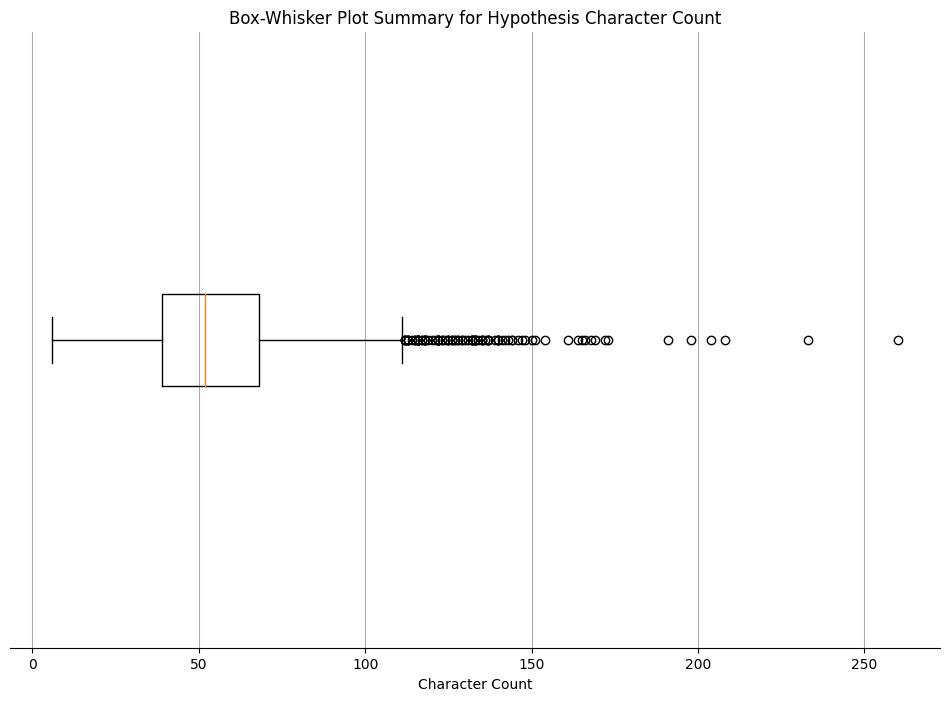

In [14]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_hypothesis_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Hypothesis Character Count")

plt.show()

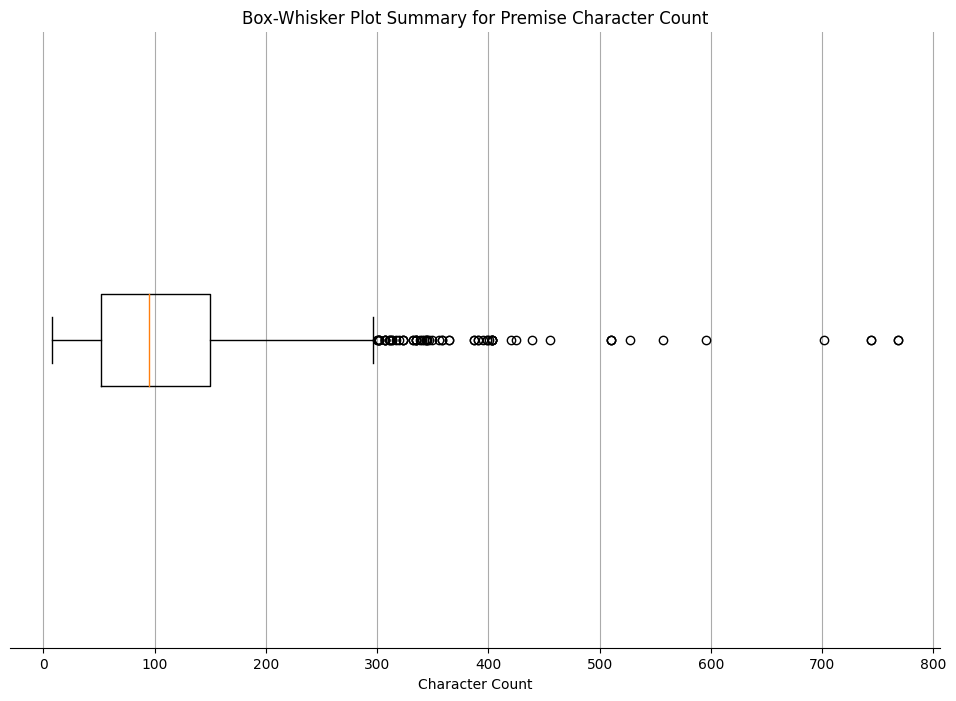

In [15]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_premise_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Premise Character Count")

plt.show()

- From the summary plots of the character counts in the texts, it can be seen that there appear to be many outliers in the distribution. This means that there exists several text elements that are much longer than upper limits of the distribution. This may affect the encoding of the textual embeddings in the model.

- Otherwise, it would seem on average that the premises are longer than the hypotheses.

#### Model Definition

In [16]:
def split_labels(x, y):
    return (x[0], x[1]), y

In [17]:
batch_size = 128

VALIDATION_SPLIT = 0.2
TRAIN_SIZE = int(bert_en_dataset.shape[0] * (1-VALIDATION_SPLIT))

training_dataset = (
    tensorflow.data.Dataset.from_tensor_slices(
        (
            bert_en_dataset[["hypothesis", "premise"]].values,
            bert_en_dataset["label"].values
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)

In [18]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_small_en_uncased", sequence_length=512)

bert_train_set = (train_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

bert_val_set = (val_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

classifier = keras_nlp.models.BertClassifier.from_preset("bert_small_en_uncased", preprocessor=None, num_classes=3)
classifier.fit(bert_train_set, validation_data=bert_val_set, epochs=3)

Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 875ms/step - loss: 1.1111 - sparse_categorical_accuracy: 0.3548 - val_loss: 1.0733 - val_sparse_categorical_accuracy: 0.4297
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 633ms/step - loss: 1.0388 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.0233 - val_sparse_categorical_accuracy: 0.5016
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 0.9457 - sparse_categorical_accuracy: 0.5884 - val_loss: 0.9437 - val_sparse_categorical_accuracy: 0.5703
